In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

### Cargo el dataset y proporciono los tipos de datos cada columna.

In [71]:
#### Importamos el dataset ya limpio y procesado anteriormente
import json

# Leer el JSON
with open("Datos/df_ly_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
df = pd.read_csv("Datos/df_ly.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    df[col] = pd.to_timedelta(df[col])

# Restaurar categoricals
for col in categorical_cols:
    df[col] = df[col].astype("category")


df.head()

,FECHA,TMAX,TMIN,NOMBRE
0,2025-03-30,28.9,21.4,AEROPARQUE AERO
1,2025-03-30,23.0,13.7,AZUL AERO
2,2025-03-30,22.6,14.6,BAHIA BLANCA AERO
3,2025-03-30,12.6,4.4,BARILOCHE AERO
4,2025-03-30,-10.3,-16.5,BASE BELGRANO II


In [72]:
# Verificación: mostrar la información del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42915 entries, 0 to 42914
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   42915 non-null  datetime64[ns]
 1   TMAX    38390 non-null  float64       
 2   TMIN    42295 non-null  float64       
 3   NOMBRE  42915 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 1.0 MB
None


### Ver el resumen de datos faltantes

In [73]:
# Me proporciona la cantidad de nulos (NaN) por columna.
df.isna().sum()

FECHA        0
TMAX      4525
TMIN       620
NOMBRE       0
dtype: int64

### Localizar las estaciones con valores faltantes en TMAX.

In [74]:
# Filtramos las filas donde TMAX es nulo
df_missing = df[df['TMAX'].isna()]

# Agrupamos por estación y contamos cuántos faltantes
missing_counts = df_missing.groupby('NOMBRE').size().reset_index(name='count_missing')

# Mostramos de mayor a menor
missing_counts = missing_counts.sort_values('count_missing', ascending=False)

print(missing_counts)


                               NOMBRE  count_missing
17                      CHAMICAL AERO            365
31   ESCUELA DE AVIACION MILITAR AERO            365
82                    RIO CUARTO AERO            365
27                       DOLORES AERO            358
88             SAN ANTONIO OESTE AERO            340
..                                ...            ...
105                       TRELEW AERO              0
111                VENADO TUERTO AERO              0
114       VILLA DE MARIA DEL RIO SECO              0
116                 VILLA GESELL AERO              0
117               VILLA REYNOLDS AERO              0

[118 rows x 2 columns]


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\1225951382.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_counts = df_missing.groupby('NOMBRE').size().reset_index(name='count_missing')


 ### Opcional: Ver cuántos datos totales distinto de valores faltantes reporta cada estación

In [75]:
total_by_station = df.groupby('NOMBRE').size().reset_index(name='count_total')
total_by_station.sort_values('count_total', ascending=False, inplace=True)

print(total_by_station)


                 NOMBRE  count_total
0       AEROPARQUE AERO          365
1             AZUL AERO          365
2     BAHIA BLANCA AERO          365
3        BARILOCHE AERO          365
4      BASE BELGRANO II          365
..                  ...          ...
14   CAMPO DE MAYO AERO          362
64                OBERA          341
40               JACHAL          340
112           VICTORICA          326
20       CHILECITO AERO          301

[118 rows x 2 columns]


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\2572886695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_station = df.groupby('NOMBRE').size().reset_index(name='count_total')


In [76]:
# 1. Calcular el número total de registros por estación
total_por_estacion = df.groupby('NOMBRE').size().reset_index(name='total_registros')

# 2. Calcular el número de registros con TMAX faltante por estación
faltantes_por_estacion = df[df['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='cantidad_valores_faltantes')

# 3. Unir ambos resultados (se usa 'left' para incluir todas las estaciones)
estaciones_faltantes = pd.merge(total_por_estacion, faltantes_por_estacion, on='NOMBRE', how='left')
estaciones_faltantes['cantidad_valores_faltantes'] = estaciones_faltantes['cantidad_valores_faltantes'].fillna(0)  # Reemplazar NaN por 0

# 4. Calcular el porcentaje de datos faltantes
estaciones_faltantes['porc_faltantes'] = (estaciones_faltantes['cantidad_valores_faltantes'] / estaciones_faltantes['total_registros']) * 100

# 5. Ordenar el resultado de mayor a menor porcentaje de faltantes
estaciones_faltantes = estaciones_faltantes.sort_values('porc_faltantes', ascending=False)
#estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')
print(estaciones_faltantes)

                               NOMBRE  total_registros  \
17                      CHAMICAL AERO              365   
31   ESCUELA DE AVIACION MILITAR AERO              365   
82                    RIO CUARTO AERO              365   
27                       DOLORES AERO              365   
88             SAN ANTONIO OESTE AERO              365   
..                                ...              ...   
105                       TRELEW AERO              365   
111                VENADO TUERTO AERO              365   
114       VILLA DE MARIA DEL RIO SECO              365   
116                 VILLA GESELL AERO              365   
117               VILLA REYNOLDS AERO              365   

     cantidad_valores_faltantes  porc_faltantes  
17                          365      100.000000  
31                          365      100.000000  
82                          365      100.000000  
27                          358       98.082192  
88                          340       93.150685  
.. 

C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\311866651.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_por_estacion = df.groupby('NOMBRE').size().reset_index(name='total_registros')
C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\311866651.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_estacion = df[df['TMAX'].isna()].groupby('NOMBRE').size().reset_index(name='cantidad_valores_faltantes')


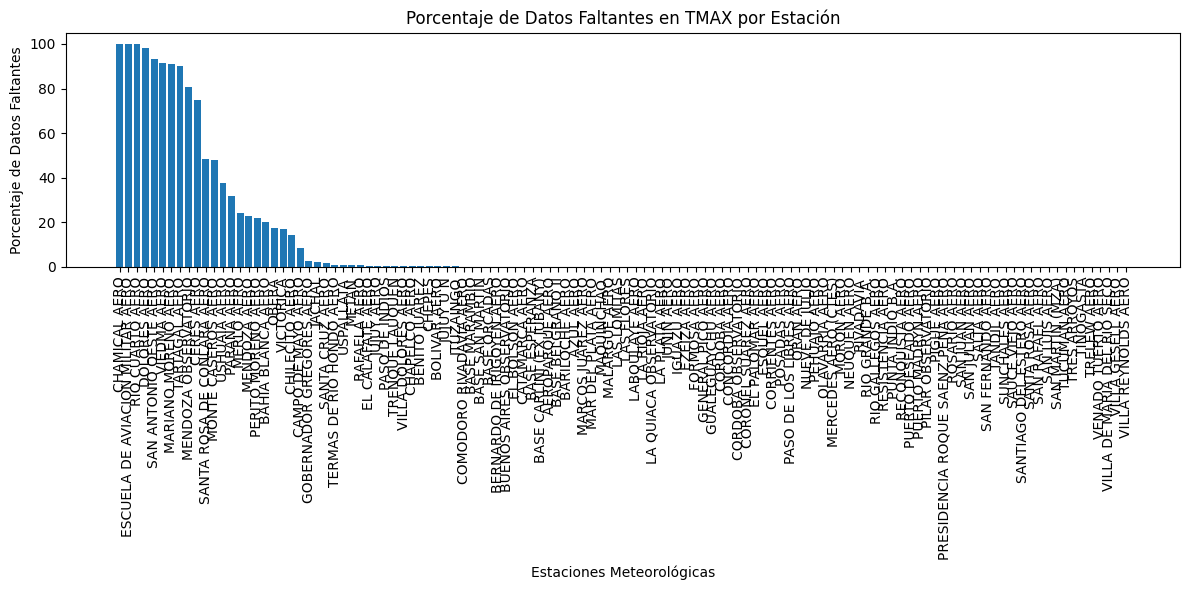

In [77]:
# Convertir el nombre de la estación en índice para facilitar la visualización
estaciones_faltantes = estaciones_faltantes.set_index('NOMBRE')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_faltantes.index, estaciones_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX por Estación')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualización
plt.tight_layout()  # Ajusta la distribución para que no se solapen elementos
plt.show()


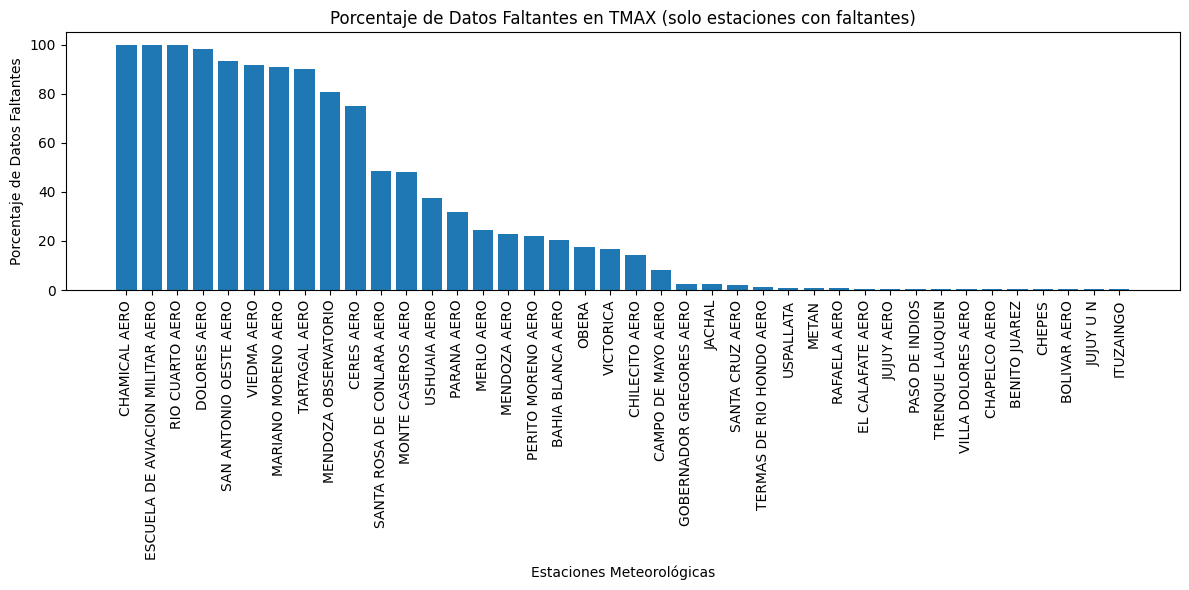

In [78]:
# Filtrar solo las estaciones que tienen algún dato faltante en TMAX
estaciones_con_faltantes = estaciones_faltantes[estaciones_faltantes['cantidad_valores_faltantes'] > 0]
#print(estaciones_con_faltantes.columns)
# Si la columna "NOMBRE" no está en las columnas (porque ya es el índice), asegúrate de que el índice tenga nombre:
if 'NOMBRE' not in estaciones_con_faltantes.columns:
    estaciones_con_faltantes.index.name = 'NOMBRE'

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(estaciones_con_faltantes.index, estaciones_con_faltantes['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes')
plt.title('Porcentaje de Datos Faltantes en TMAX (solo estaciones con faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejor visualización
plt.tight_layout()
plt.show()

In [79]:
umbral = 50

# Si "NOMBRE" no es una columna, restablecemos el índice:
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones válidas según el umbral (menos del 50% de datos faltantes)
estaciones_validas = estaciones_faltantes[estaciones_faltantes['porc_faltantes'] < umbral]['NOMBRE']

# Seleccionar del dataset original solo las filas correspondientes a las estaciones válidas
df_valido = df[df['NOMBRE'].isin(estaciones_validas)].copy()

print("Estaciones válidas según el criterio:")
print(estaciones_validas)

Estaciones válidas según el criterio:
10      SANTA ROSA DE CONLARA AERO
11              MONTE CASEROS AERO
12                    USHUAIA AERO
13                     PARANA AERO
14                      MERLO AERO
                  ...             
113                    TRELEW AERO
114             VENADO TUERTO AERO
115    VILLA DE MARIA DEL RIO SECO
116              VILLA GESELL AERO
117            VILLA REYNOLDS AERO
Name: NOMBRE, Length: 108, dtype: category
Categories (118, object): ['AEROPARQUE AERO', 'AZUL AERO', 'BAHIA BLANCA AERO', 'BARILOCHE AERO', ..., 'VILLA DE MARIA DEL RIO SECO', 'VILLA DOLORES AERO', 'VILLA GESELL AERO', 'VILLA REYNOLDS AERO']


## 🎯 Criterio de exclusión de estaciones meteorológicas por umbral de datos faltantes.

Para garantizar la calidad del análisis, se establece un **criterio mínimo de completitud de los datos** por estación meteorológica. Este criterio se basa en un **umbral de porcentaje de datos faltantes**:

- Si una estación presenta **más del 50 % de datos faltantes**, se considera que **no cuenta con suficiente información confiable**, y por lo tanto se **excluye del análisis posterior** o se trata por separado.

- En cambio, si el **porcentaje de datos faltantes es menor o igual al 50 %**, la estación conserva una **cantidad suficiente de datos observados**, lo que permite aplicar técnicas de imputación con mayor confianza.

Este criterio busca asegurar que las imputaciones no se realicen sobre estaciones con datos extremadamente escasos, lo que podría introducir ruido o errores importantes en el modelo.

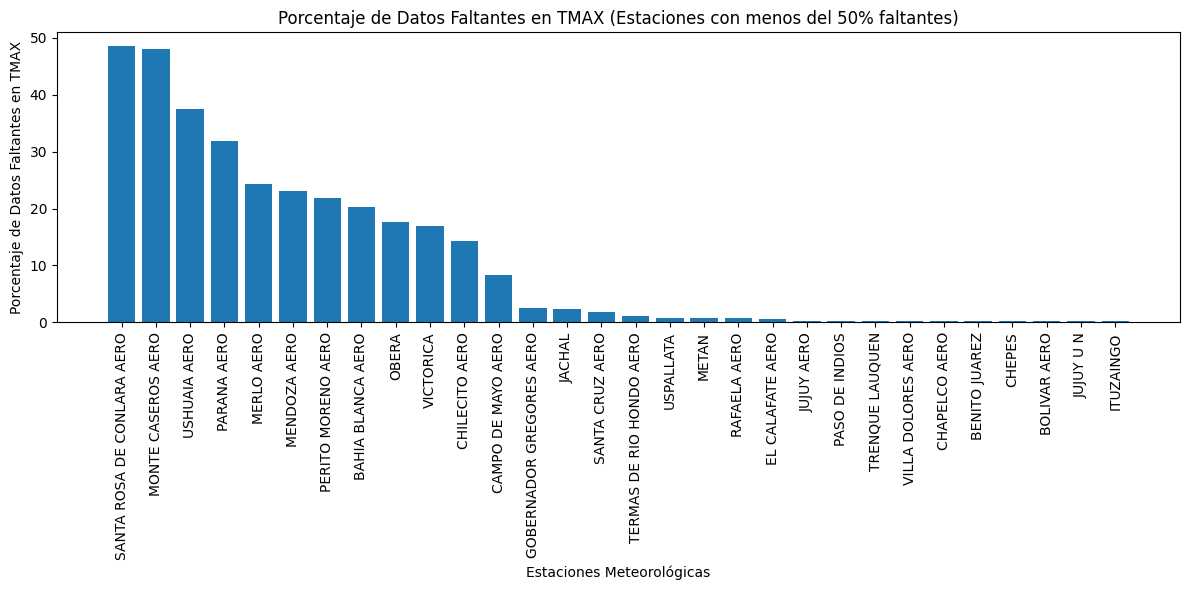

In [80]:
# Definir el umbral de faltantes (por ejemplo, 50%)
umbral = 50

# Asegurarse de que "NOMBRE" esté en el DataFrame
if 'NOMBRE' not in estaciones_faltantes.columns:
    estaciones_faltantes = estaciones_faltantes.reset_index()

# Filtrar las estaciones válidas según el umbral
estaciones_validas_df = estaciones_faltantes[(estaciones_faltantes['porc_faltantes'] < umbral) &
    (estaciones_faltantes['cantidad_valores_faltantes'] > 0)]

# Graficar el histograma (barras)
plt.figure(figsize=(12, 6))
plt.bar(estaciones_validas_df['NOMBRE'], estaciones_validas_df['porc_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes en TMAX')
plt.title(f'Porcentaje de Datos Faltantes en TMAX (Estaciones con menos del {umbral}% faltantes)')
plt.xticks(rotation=90)  # Gira los nombres para mejorar la legibilidad
plt.tight_layout()
plt.show()


In [81]:
total_estaciones = estaciones_faltantes['NOMBRE'].nunique()
validas = estaciones_validas_df['NOMBRE'].nunique()
excluidas = total_estaciones - validas
print(f"📌 total de estaciones: {total_estaciones}")
print(f"📌 Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: {excluidas}")
estaciones_fuera = estaciones_faltantes[
    estaciones_faltantes['porc_faltantes'] >= umbral
]['NOMBRE'].unique()

print(f"📌 Estaciones válidas,que no superan el 50% con datos faltantes en TMAX y que tienen datos faltantes: {validas}")
print(f"📌 cantidad de estaciones excluidas:{excluidas} ")

📌 total de estaciones: 118
📌 Estaciones que no superan el 50% de datos faltantes y no tienen datos faltantes en TMAX: 88
📌 Estaciones válidas,que no superan el 50% con datos faltantes en TMAX y que tienen datos faltantes: 30
📌 cantidad de estaciones excluidas:88 


In [82]:
# Agrupar por estación para quedarte con un solo valor por estación
estaciones_agru = estaciones_faltantes.groupby('NOMBRE')['porc_faltantes'].max().reset_index()

# Estaciones excluidas (porcentaje de faltantes >= umbral)
estaciones_fuera = estaciones_agru[estaciones_agru['porc_faltantes'] >= umbral]

# Estaciones válidas
estaciones_validas = estaciones_agru[estaciones_agru['porc_faltantes'] < umbral]

# Cálculos
total = estaciones_agru['NOMBRE'].nunique()
excluidas = estaciones_fuera['NOMBRE'].nunique()
validas = estaciones_validas['NOMBRE'].nunique()

print(f"📊 Total de estaciones: {total}")
print(f"✅ Estaciones válidas (menos del {umbral}% de datos faltantes): {validas}")
print(f"❌ Estaciones excluidas por superar el umbral: {excluidas}")
print("🔍 Lista de estaciones excluidas:")
estaciones_fuera = estaciones_fuera['NOMBRE'].tolist()
print(estaciones_fuera)
# Crear un nuevo DataFrame que solo contenga las filas con 'NOMBRE' presente en la lista 'estaciones_fuera'
df_estaciones_fuera = df[df['NOMBRE'].isin(estaciones_fuera)].copy()




📊 Total de estaciones: 118
✅ Estaciones válidas (menos del 50% de datos faltantes): 108
❌ Estaciones excluidas por superar el umbral: 10
🔍 Lista de estaciones excluidas:
['CERES AERO', 'CHAMICAL AERO', 'DOLORES AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'MARIANO MORENO AERO', 'MENDOZA OBSERVATORIO', 'RIO CUARTO AERO', 'SAN ANTONIO OESTE AERO', 'TARTAGAL AERO', 'VIEDMA AERO']


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\2732013482.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estaciones_agru = estaciones_faltantes.groupby('NOMBRE')['porc_faltantes'].max().reset_index()


              NOMBRE  total_registros  cantidad_faltantes  \
0    AEROPARQUE AERO                0                   0   
1          AZUL AERO                0                   0   
2  BAHIA BLANCA AERO                0                   0   
3     BARILOCHE AERO                0                   0   
4   BASE BELGRANO II                0                   0   

   porcentaje_faltantes  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\39545988.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_missing_stats = df_estaciones_fuera.groupby('NOMBRE').agg(


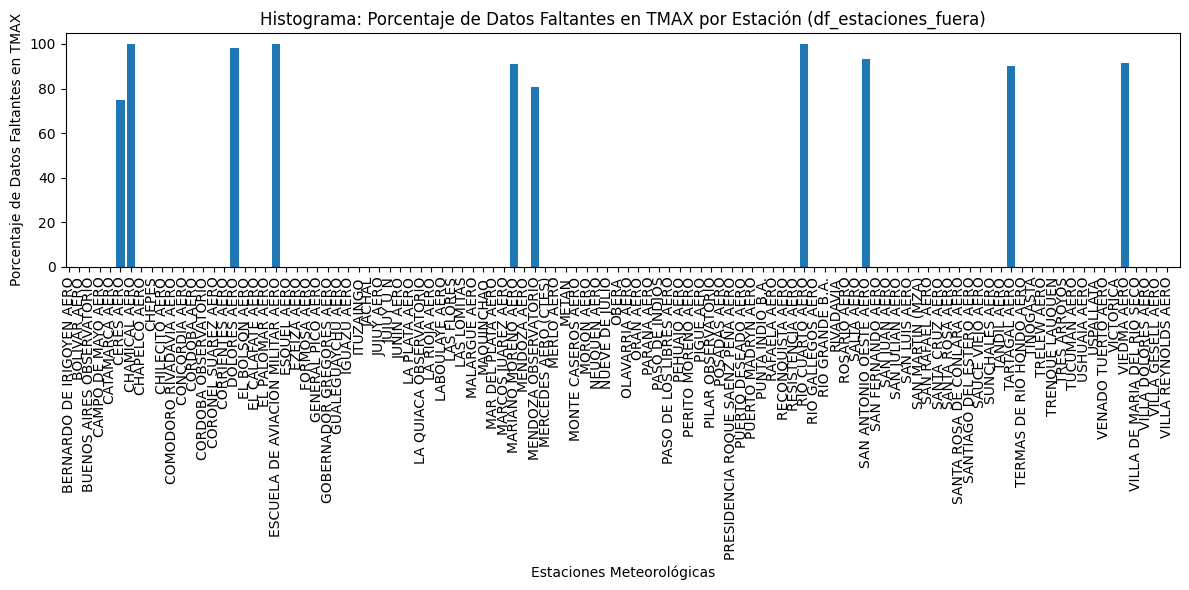

In [83]:
# Agrupar por estación para obtener el número total de registros y la cantidad de datos faltantes en TMAX
df_missing_stats = df_estaciones_fuera.groupby('NOMBRE').agg(
    total_registros=('TMAX', 'size'),
    cantidad_faltantes=('TMAX', lambda x: x.isna().sum())
).reset_index()

# Calcular el porcentaje de datos faltantes por estación
df_missing_stats['porcentaje_faltantes'] = (df_missing_stats['cantidad_faltantes'] / df_missing_stats['total_registros']) * 100

# Visualizar los primeros registros para ver la estructura
print(df_missing_stats.head())

# Crear el histograma (en realidad, un gráfico de barras) con los porcentajes de datos faltantes
plt.figure(figsize=(12, 6))
plt.bar(df_missing_stats['NOMBRE'], df_missing_stats['porcentaje_faltantes'])
plt.xlabel('Estaciones Meteorológicas')
plt.ylabel('Porcentaje de Datos Faltantes en TMAX')
plt.title('Histograma: Porcentaje de Datos Faltantes en TMAX por Estación (df_estaciones_fuera)')
plt.xticks(rotation=90)  # Rotar etiquetas para una mejor legibilidad
plt.tight_layout()  # Ajustar la distribución para que no se solapen los elementos
plt.show()


### En la siguiente celda se genera un nuevo dataset, a partir del original, que incluye únicamente las estaciones que no superan el 50 % de datos faltantes en la columna TMAX.

In [84]:
df_completo = df_valido.copy() 
df_completo
df_completo.columns
cantidad_de_estaciones= df_completo['NOMBRE'].nunique()
print ("cantidad de estaiones luego de aplicar el criterio del 50 % umbral:", cantidad_de_estaciones )

cantidad de estaiones luego de aplicar el criterio del 50 % umbral: 108


In [85]:
df_completo['mes'] = df_completo['FECHA'].dt.month
df_completo
print(df_completo.isna().sum())

FECHA        0
TMAX      1169
TMIN       613
NOMBRE       0
mes          0
dtype: int64


### Se verifica la cantidad total de datos faltantes en TMAX y TMIN antes de realizar la primera imputación.

In [86]:
faltantes = df_completo[['TMAX', 'TMIN']].isna().sum()
print("Cantidad de datos faltantes antes de realizar la priemra imputación:\n", faltantes)
print(df_completo.info())

Cantidad de datos faltantes antes de realizar la priemra imputación:
 TMAX    1169
TMIN     613
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 39265 entries, 0 to 42914
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   39265 non-null  datetime64[ns]
 1   TMAX    38096 non-null  float64       
 2   TMIN    38652 non-null  float64       
 3   NOMBRE  39265 non-null  category      
 4   mes     39265 non-null  int32         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1)
memory usage: 1.4 MB
None


### El bloque de código siguiente imputa con el algoritmno KNNImputer al data frame 'df_completo' conformado por estaciones metereológica con menos del 50% de datos faltantes. 

In [87]:
# Asegurarte de tener la fecha como datetime
df_completo['FECHA'] = pd.to_datetime(df_completo['FECHA'], errors='coerce')
df_completo['mes'] = df_completo['FECHA'].dt.month

# Definir la función de imputación por grupo
def imputar_knn_por_grupo(grupo):
    imputer = KNNImputer(n_neighbors=3)  # Podés ajustar el número de vecinos
    columnas_a_imputar = ['TMAX', 'TMIN']
    grupo_imputado = grupo.copy()
    # Verificamos que haya suficientes filas con datos para aplicar KNN
    if grupo[columnas_a_imputar].notna().sum().min() >= 2:
        imputer = KNNImputer(n_neighbors=2)  # Usamos 2 vecinos por seguridad
        grupo_imputado[columnas_a_imputar] = imputer.fit_transform(grupo[columnas_a_imputar])

    # Si no hay suficientes datos, se deja sin modificar
    return grupo_imputado

# Aplicar la imputación agrupando por estación y mes
df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)

# Confirmar que ya no hay valores faltantes en TMAX ni TMIN
print("Faltantes luego de realizar una primera imputación:")
print(df_imputado[['TMAX', 'TMIN']].isna().sum())
print(df_imputado.columns)

C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\1505873712.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)


Faltantes luego de realizar una primera imputación:
TMAX    635
TMIN    245
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes'], dtype='object')


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\1505873712.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputado = df_completo.groupby(['NOMBRE', 'mes']).apply(imputar_knn_por_grupo).reset_index(drop=True)


In [88]:
faltantes_residuales = df_imputado[df_imputado[['TMAX', 'TMIN']].isna().any(axis=1)]
resumen = faltantes_residuales.groupby(['NOMBRE', 'mes']).size().reset_index(name='registros_faltantes')
print(resumen.sort_values('registros_faltantes', ascending=False))


                  NOMBRE  mes  registros_faltantes
261     EL CALAFATE AERO    1                   31
269     EL CALAFATE AERO   12                   31
522           MERLO AERO    1                   31
129   CAMPO DE MAYO AERO    5                   31
495         MENDOZA AERO    1                   31
...                  ...  ...                  ...
1041  VILLA DOLORES AERO   10                    0
1042  VILLA DOLORES AERO   11                    0
1043  VILLA DOLORES AERO   12                    0
1044   VILLA GESELL AERO    1                    0
3        AEROPARQUE AERO    5                    0

[1062 rows x 3 columns]


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\528578257.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = faltantes_residuales.groupby(['NOMBRE', 'mes']).size().reset_index(name='registros_faltantes')


### Conclusión de la primera imputación:
- Al dataframe 'df_imputado', que contiene únicamente las estaciones con al menos el 50 % de datos completos, se le aplicó imputación utilizando el algoritmo KNNImputer. Sin embargo, aún persisten algunos valores faltantes.

-----------------------------

### El siguiente bloque de código carga un archivo de estaciones meteorológicas en formato de ancho fijo, convierte las coordenadas de grados y minutos a decimales, y limpia los nombres para facilitar su empleo en análisis o uniones con otros datasets.

In [89]:
def convertir_a_decimal(grados_col, minutos_col):
    return pd.to_numeric(grados_col, errors='coerce') + pd.to_numeric(minutos_col, errors='coerce') / 60

columnas = ['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI']
df_estaciones = pd.read_fwf('Datos/estaciones_smn.txt', encoding='latin1', skiprows=1, names=columnas)
print(df_estaciones.columns)
df_estaciones['LATITUD'] = convertir_a_decimal(df_estaciones['LAT_G'], df_estaciones['LAT_M'])
df_estaciones['LONGITUD'] = convertir_a_decimal(df_estaciones['LON_G'], df_estaciones['LON_M'])
df_estaciones['NOMBRE'] = df_estaciones['NOMBRE'].str.strip()

Index(['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA',
       'NRO', 'NroOACI'],
      dtype='object')


### Este bloque limpia y corrige nombres de estaciones en el dataset imputado para que coincidan con los del dataset de coordenadas, y luego los une mediante un merge para incorporar información geográfica.

In [90]:
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].str.strip()

# Aplicar correcciones si fuera necesario
correcciones = {
    'ESCUELA DE AVIACION MILITAR AERO': 'ESCUELA DE AVIACION MILITAR AE',
    'PRESIDENCIA ROQUE SAENZ PEÑA AERO': 'PRESIDENCIA ROQUE SAENZ PEÑA A'
}
df_imputado['NOMBRE'] = df_imputado['NOMBRE'].replace(correcciones)

df_imputado_geo = pd.merge(df_imputado, df_estaciones, on='NOMBRE', how='left')


### Este bloque convierte las columnas de coordenadas a valores numéricos y muestra cuántos valores faltantes hay en las variables geográficas y de temperatura, además de imprimir las columnas y la estructura del data frame.

In [91]:
for col in ['LATITUD', 'LONGITUD', 'ALTURA']:
    df_imputado_geo[col] = pd.to_numeric(df_imputado_geo[col], errors='coerce')

print(df_imputado_geo[['LATITUD', 'LONGITUD', 'ALTURA','TMAX','TMIN','LATITUD','LONGITUD']].isna().sum())
print(df_imputado_geo.columns)
print(df_imputado_geo.info())



LATITUD       0
LONGITUD      0
ALTURA        0
TMAX        635
TMIN        245
LATITUD       0
LONGITUD      0
dtype: int64
Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'LAT_G', 'LAT_M',
       'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI', 'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38630 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   LAT_G      39265 non-null  object        
 7   LAT_M      39265 non-null  object        
 8   LON_G      39265 non-null  object        
 9   LON_M      39265 non-null  object        
 10  ALTURA     39265 n

### Este bloque elimina las columnas intermedias usadas para calcular latitud y longitud, y luego muestra las columnas y la información general del DataFrame resultante 'df_imputado'.

In [92]:
columnas_a_eliminar = ['LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'NRO', 'NroOACI']
df_imputado_geo = df_imputado_geo.drop(columns=columnas_a_eliminar)
print(df_imputado_geo.columns)
print(df_imputado_geo.info())


Index(['FECHA', 'TMAX', 'TMIN', 'NOMBRE', 'mes', 'PROVINCIA', 'ALTURA',
       'LATITUD', 'LONGITUD'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       38630 non-null  float64       
 2   TMIN       39020 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   ALTURA     39265 non-null  int64         
 7   LATITUD    39265 non-null  float64       
 8   LONGITUD   39265 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 2.5+ MB
None


### Este bloque de código separa las estaciones meteorológicas del continente y de la Antártida en dos datasets distintos, y muestra cuántos registros y valores faltantes (TMAX, TMIN) hay en cada región antes de la imputación.

In [93]:
# Identificar estaciones antárticas por provincia
es_antartida = df_imputado_geo['PROVINCIA'].str.upper() == 'ANTARTIDA'

# Separar en dos datasets
df_antartida = df_imputado_geo[es_antartida].copy()
df_continente = df_imputado_geo[~es_antartida].copy()

print("Estaciones antárticas:", df_antartida['NOMBRE'].unique())
print("Registros en continente:", len(df_continente))
print("Registros en Antártida:", len(df_antartida))
# datops faltantes del continente
print("➡️ Faltantes en el continente antes de imputar:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())
# datosfaltante de la antartida
print("✅ Faltantes en la Antártida antes de imputar:")
print(df_antartida[['TMAX', 'TMIN']].isna().sum())

Estaciones antárticas: ['BASE BELGRANO II' 'BASE CARLINI (EX JUBANY)' 'BASE ESPERANZA'
 'BASE MARAMBIO' 'BASE ORCADAS' 'BASE SAN MARTIN']
Registros en continente: 37075
Registros en Antártida: 2190
➡️ Faltantes en el continente antes de imputar:
TMAX    635
TMIN    245
dtype: int64
✅ Faltantes en la Antártida antes de imputar:
TMAX    0
TMIN    0
dtype: int64


### A continucación, se imputa únicamente el dataset del continente por separado para evitar que el algoritmo KNN utilice estaciones antárticas como vecinas de referencia, ya que presentan condiciones climáticas extremadamente distintas que podrían sesgar la imputación. Esto asegura una imputación más precisa y coherente con el entorno geográfico real.

In [94]:
# Definir columnas del modelo
columnas_modelo = ['TMAX', 'TMIN', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']

# Escalar
scaler = StandardScaler()
df_continente_scaled = pd.DataFrame(
    scaler.fit_transform(df_continente[columnas_modelo]),
    columns=columnas_modelo,
    index=df_continente.index
)

# Separar filas con y sin faltantes
filas_con_nan = df_continente_scaled[['TMAX', 'TMIN']].isna().any(axis=1)
df_a_imputar = df_continente_scaled[filas_con_nan]
df_completos = df_continente_scaled[~filas_con_nan]

# Tomar muestra de referencia (5000 como máximo)
df_referencia = df_completos.sample(n=5000, random_state=42) if len(df_completos) > 5000 else df_completos.copy()

# Concatenar y aplicar KNN
df_union = pd.concat([df_a_imputar, df_referencia])
knn = KNNImputer(n_neighbors=5)
df_union_imputado = pd.DataFrame(knn.fit_transform(df_union), columns=columnas_modelo, index=df_union.index)

# Recuperar los valores imputados
df_imputado_final = df_union_imputado.loc[df_a_imputar.index, ['TMAX', 'TMIN']]

# Reemplazar en el dataframe original
df_continente.loc[df_a_imputar.index, ['TMAX', 'TMIN']] = df_imputado_final[['TMAX', 'TMIN']]
print("➡️ Faltantes en el continente después de una segunda imputación:")
print(df_continente[['TMAX', 'TMIN']].isna().sum())



➡️ Faltantes en el continente después de una segunda imputación:
TMAX    0
TMIN    0
dtype: int64


### Concateno ambos dataframe del continente y de la Antártida llamado 'df_final'
- Además, tener en cuenta que este dataset o data frame tiene solo estaciones meterológica que cuentan don datos faltantes menos del 50%.
  Es decir, las estaciones meterologicas que cuentan con más del 50% de datos faltantes están excluidas.

In [95]:
df_final = pd.concat([df_continente, df_antartida], ignore_index=True)
df_final.to_excel("dataset_imputado_final.xlsx", index=False)
print("➡️ Faltantes tanto en el continente como en la Antártida después de imputar:")
print(df_final[['TMAX', 'TMIN']].isna().sum())
cantidad_de_estaciones_df_final = df_final['NOMBRE'].nunique()
print("Total de estaciones:", cantidad_de_estaciones_df_final)
print(df_final.info())


➡️ Faltantes tanto en el continente como en la Antártida después de imputar:
TMAX    0
TMIN    0
dtype: int64
Total de estaciones: 108
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39265 entries, 0 to 39264
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39265 non-null  datetime64[ns]
 1   TMAX       39265 non-null  float64       
 2   TMIN       39265 non-null  float64       
 3   NOMBRE     39265 non-null  object        
 4   mes        39265 non-null  int32         
 5   PROVINCIA  39265 non-null  object        
 6   ALTURA     39265 non-null  int64         
 7   LATITUD    39265 non-null  float64       
 8   LONGITUD   39265 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [96]:
### Exportación para leer en otra Notebook

# Detectar columnas categóricas
categorical_cols = [col for col, dtype in df_final.dtypes.items() if str(dtype) == 'category']

# Guardar los tipos como strings
dtypes_str = {col: str(dtype) for col, dtype in df_final.dtypes.items()}

# Guardar todo en un solo JSON
info = {
    "dtypes": dtypes_str,
    "categoricals": categorical_cols
}

with open("Datos/df_final_dtypes.json", "w") as f:
    json.dump(info, f)

# exportar CSV
df_final.to_csv('Datos/df_final.csv', index=False)


### Este código lee el archivo de estaciones meteorológicas del SMN, calcula latitud y longitud en formato decimal, y busca la estación `"escuela de aviacion militar ae cordoba"` en el DataFrame resultante.


In [97]:

def convertir_a_decimal(grados_col, minutos_col):
    return pd.to_numeric(grados_col, errors='coerce') + pd.to_numeric(minutos_col, errors='coerce') / 60

# Definir las columnas para la lectura del archivo
columnas = ['NOMBRE', 'PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA', 'NRO', 'NroOACI']

# Leer el archivo de texto con las estaciones
df_estaciones_1 = pd.read_fwf('Datos/estaciones_smn.txt', encoding='latin1', skiprows=1, names=columnas)

# Calcular las coordenadas decimales
df_estaciones_1['LATITUD'] = convertir_a_decimal(df_estaciones_1['LAT_G'], df_estaciones_1['LAT_M'])
df_estaciones_1['LONGITUD'] = convertir_a_decimal(df_estaciones_1['LON_G'], df_estaciones_1['LON_M'])
df_estaciones_1['ALTURA'] = pd.to_numeric(df_estaciones_1['ALTURA'].str.strip(), errors='coerce')

# Limpiar los nombres quitando espacios de ambos lados
df_estaciones_1['NOMBRE'] = df_estaciones_1['NOMBRE'].str.strip()

# Definir el nombre de la estación que queremos buscar.
# Usamos minúsculas para la comparación insensible a mayúsculas/minúsculas.
estacion_buscada = 'escuela de aviacion militar ae cordoba'

# Filtrar el DataFrame, convirtiendo ambos a minúsculas para la comparación
resultado = df_estaciones_1[df_estaciones_1['NOMBRE'].str.lower() == estacion_buscada]

print("Resultado de la búsqueda en el DataFrame:")
print(resultado)




Resultado de la búsqueda en el DataFrame:
Empty DataFrame
Columns: [NOMBRE, PROVINCIA, LAT_G, LAT_M, LON_G, LON_M, ALTURA, NRO, NroOACI, LATITUD, LONGITUD]
Index: []


In [98]:
# Buscar registros que contengan la palabra "escuela" en la columna NOMBRE
resultado = df_estaciones_1[df_estaciones_1['NOMBRE'].str.lower().str.contains("escuela", na=False)]
print(resultado[['NOMBRE']])

                            NOMBRE
47  ESCUELA DE AVIACION MILITAR AE


In [99]:
print(df_estaciones_1.iloc[46:50])


                            NOMBRE PROVINCIA LAT_G LAT_M LON_G LON_M  ALTURA  \
46            CORDOBA OBSERVATORIO   CORDOBA   -31    25   -64    11   425.0   
47  ESCUELA DE AVIACION MILITAR AE   CORDOBA   -31    26   -64    16   502.0   
48                              RO       NaN   NaN   NaN   NaN   NaN     NaN   
49                  LABOULAYE AERO   CORDOBA   -34     7   -63    22   137.0   

        NRO NroOACI    LATITUD   LONGITUD  
46  87345.0    SACK -30.583333 -63.816667  
47  87347.0    SACE -30.566667 -63.733333  
48      NaN     NaN        NaN        NaN  
49  87534.0    SAOL -33.883333 -62.633333  


In [100]:
# Identificar filas que contengan casi toda la información nula (excepto en NOMBRE)
mask_huerfana = df_estaciones_1[['PROVINCIA', 'LAT_G', 'LAT_M', 'LON_G', 'LON_M', 'ALTURA']].isnull().all(axis=1)

# Recorrer y, si la fila es huérfana, unir su contenido a la fila anterior en NOMBRE
indices_huerfanos = df_estaciones_1[mask_huerfana].index
for i in indices_huerfanos:
    if i > 0:
        # Concatenamos con un espacio el contenido de la fila huérfana a la fila anterior
        df_estaciones_1.at[i-1, 'NOMBRE'] = (df_estaciones_1.at[i-1, 'NOMBRE'] + " " + df_estaciones_1.at[i, 'NOMBRE']).strip()

# Eliminar las filas huérfanas
df_estaciones_1 = df_estaciones_1[~mask_huerfana].reset_index(drop=True)

# Verificar el resultado
print(df_estaciones_1.iloc[45:50])


                               NOMBRE PROVINCIA LAT_G LAT_M LON_G LON_M  \
45               CORDOBA OBSERVATORIO   CORDOBA   -31    25   -64    11   
46  ESCUELA DE AVIACION MILITAR AE RO   CORDOBA   -31    26   -64    16   
47                     LABOULAYE AERO   CORDOBA   -34     7   -63    22   
48                 MARCOS JUAREZ AERO   CORDOBA   -32    40   -62     9   
49                 PILAR OBSERVATORIO   CORDOBA   -31    40   -63    52   

    ALTURA      NRO NroOACI    LATITUD   LONGITUD  
45   425.0  87345.0    SACK -30.583333 -63.816667  
46   502.0  87347.0    SACE -30.566667 -63.733333  
47   137.0  87534.0    SAOL -33.883333 -62.633333  
48   114.0  87467.0    SAOM -31.333333 -61.850000  
49   338.0  87349.0    SACI -30.333333 -62.133333  


In [101]:
# Convertir a minúsculas para comparar y reemplazar
df_estaciones_1['NOMBRE'] = df_estaciones_1['NOMBRE'].str.lower()

# Revisar el contenido de la fila afectada
print(df_estaciones_1.loc[df_estaciones_1['NOMBRE'].str.contains("escuela de aviacion militar ae", na=False)])

# Si detectas que el registro es "escuela de aviacion militar ae ro", reemplazarlo
df_estaciones_1['NOMBRE'] = df_estaciones_1['NOMBRE'].replace(
    'escuela de aviacion militar ae ro', 'escuela de aviacion militar ae cordoba'
)

# Verificar el cambio:
print(df_estaciones_1.loc[df_estaciones_1['NOMBRE'].str.contains("escuela", na=False)])
print(df_estaciones_1[['LATITUD','LONGITUD','ALTURA']].dtypes)


                               NOMBRE PROVINCIA LAT_G LAT_M LON_G LON_M  \
46  escuela de aviacion militar ae ro   CORDOBA   -31    26   -64    16   

    ALTURA      NRO NroOACI    LATITUD   LONGITUD  
46   502.0  87347.0    SACE -30.566667 -63.733333  
                                    NOMBRE PROVINCIA LAT_G LAT_M LON_G LON_M  \
46  escuela de aviacion militar ae cordoba   CORDOBA   -31    26   -64    16   

    ALTURA      NRO NroOACI    LATITUD   LONGITUD  
46   502.0  87347.0    SACE -30.566667 -63.733333  
LATITUD     float64
LONGITUD    float64
ALTURA      float64
dtype: object


In [102]:
# Definir el nombre de la estación que se quiere verificar
estacion_busqueda = 'escuela de aviacion militar ae cordoba'

# Filtrar el DataFrame para encontrar la estación
resultado = df_estaciones_1[df_estaciones_1['NOMBRE'] == estacion_busqueda]

# Mostrar el resultado
print(resultado)


                                    NOMBRE PROVINCIA LAT_G LAT_M LON_G LON_M  \
46  escuela de aviacion militar ae cordoba   CORDOBA   -31    26   -64    16   

    ALTURA      NRO NroOACI    LATITUD   LONGITUD  
46   502.0  87347.0    SACE -30.566667 -63.733333  


In [103]:
print(df_estaciones_fuera['NOMBRE'].unique())

['CERES AERO', 'CHAMICAL AERO', 'DOLORES AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'MARIANO MORENO AERO', 'MENDOZA OBSERVATORIO', 'RIO CUARTO AERO', 'SAN ANTONIO OESTE AERO', 'TARTAGAL AERO', 'VIEDMA AERO']
Categories (118, object): ['AEROPARQUE AERO', 'AZUL AERO', 'BAHIA BLANCA AERO', 'BARILOCHE AERO', ..., 'VILLA DE MARIA DEL RIO SECO', 'VILLA DOLORES AERO', 'VILLA GESELL AERO', 'VILLA REYNOLDS AERO']


In [104]:
# Normalizar los nombres en ambos DataFrames (quita espacios y convertir a minúsculas)
df_estaciones_fuera['NOMBRE'] = df_estaciones_fuera['NOMBRE'].str.strip().str.lower()
df_estaciones_1['NOMBRE'] = df_estaciones_1['NOMBRE'].str.strip().str.lower()

# Reemplazar el nombre en df_estaciones_fuera que no coincide con el del DataFrame de coordenadas
df_estaciones_fuera['NOMBRE'] = df_estaciones_fuera['NOMBRE'].replace(
    'escuela de aviacion militar aero',  # valor presente en df_estaciones_fuera
    'escuela de aviacion militar ae cordoba'  # valor correcto tal como aparece en df_estaciones
)

# Seleccionar las columnas relevantes del DataFrame de estaciones que contienen las coordenadas
columnas_coordenadas = ['NOMBRE', 'PROVINCIA', 'LATITUD', 'LONGITUD', 'ALTURA']

# Realizar el merge entre df_estaciones_fuera y df_estaciones usando la columna 'NOMBRE'
df_estaciones_fuera_geo = pd.merge(
    df_estaciones_fuera,
    df_estaciones_1[columnas_coordenadas],
    on='NOMBRE',
    how='left'
)

# Verificar el resultado
print(df_estaciones_fuera_geo.head())
# Revisar estaciones sin información completa
missing_coords = df_estaciones_fuera_geo[df_estaciones_fuera_geo[['LATITUD', 'LONGITUD', 'ALTURA']].isnull().any(axis=1)]
print("Estaciones sin coordenadas completas:")
print(missing_coords['NOMBRE'].unique())

missing_counts = df_estaciones_fuera_geo[['ALTURA', 'LATITUD', 'LONGITUD']].isna().sum()
print("Cantidad de datos faltantes:")
print(missing_counts)


       FECHA  TMAX  TMIN                                  NOMBRE  \
0 2025-03-30  31.8  21.0                              ceres aero   
1 2025-03-30   NaN  21.0                           chamical aero   
2 2025-03-30  28.4  16.0                            dolores aero   
3 2025-03-30   NaN  14.4  escuela de aviacion militar ae cordoba   
4 2025-03-30   NaN  17.0                     mariano moreno aero   

      PROVINCIA    LATITUD   LONGITUD  ALTURA  
0      SANTA FE -28.133333 -60.066667    88.0  
1      LA RIOJA -29.666667 -65.716667   461.0  
2  BUENOS AIRES -35.683333 -56.283333     9.0  
3       CORDOBA -30.566667 -63.733333   502.0  
4  BUENOS AIRES -33.450000 -57.216667    32.0  
Estaciones sin coordenadas completas:
[]
Cantidad de datos faltantes:
ALTURA      0
LATITUD     0
LONGITUD    0
dtype: int64


In [105]:
# Filtrar el DataFrame para obtener únicamente la estación "ceres aero"
df_ceres = df_estaciones_fuera_geo[df_estaciones_fuera_geo['NOMBRE'].str.lower() == 'ceres aero']

# Contar los valores faltantes en las columnas de interés
missing_ceres = df_ceres['TMAX'].isna().sum()
print("Cantidad de datos faltantes en CERES - en la variable TMAX:")
print(missing_ceres)


Cantidad de datos faltantes en CERES - en la variable TMAX:
273


### Los bloques de código anteriores proporcionan un datagrama que contienen las estaciones condatos valores faltantes mayores al 50% y sus coordenadas geograficas. 

###  Ahora el objetivo es recuperar, si es posible, estaciones valiosas que fueron excluidas por tener demasiados faltantes… pero no al punto de ser irrecuperables.

- La estrategias es la siguiente: 
    - separar en grupos (Grupo A y Grupo B) te permite aplicar criterios justos, sin forzar la imputación a ciegas.

### 🟢 Grupo A – Estaciones parcialmente válidas

Estas estaciones tienen al menos un 20 % de datos reales de **TMAX** (≈73 días en el año).

**📌 Acciones:**

- Evaluarlas por cercanía geográfica.
- Imputar por **mes + ubicación** (KNN, como ya venimos trabajando).

---

### 🔴 Grupo B – Estaciones sin datos útiles

Tienen 0 o muy pocos valores de **TMAX**. No se puede imputar nada confiable.

**📌 Acciones:**

- Se las excluye del análisis cuantitativo.



### ✅ El paso siguiente es: 

1. Calcular el **porcentaje de datos no nulos en TMAX** para cada estación excluida.

2. Filtrar las que tienen **al menos un 20 % de registros válidos** → serán **Grupo A**.

3. **Imputar por cercanía** esas estaciones (usando coordenadas geográficas y mes).

4. Las demás, clasificarlas como **Grupo B** y eventualmente **excluirlas del análisis**.


In [106]:

# Supongamos que df_completo tiene 365 días por estación (o cerca de eso)
umbral = 73

# Calcular cuántos registros válidos (no NaN) tiene cada estación para TMAX
tmax_counts = df_estaciones_fuera_geo.groupby('NOMBRE')['TMAX'].count().reset_index(name='dias_TMAX_validos')

# Clasificar según el umbral
grupo_A = tmax_counts[tmax_counts['dias_TMAX_validos'] >= umbral]
grupo_B = tmax_counts[tmax_counts['dias_TMAX_validos'] < umbral]

print("Estaciones Grupo A (≥73 días TMAX válidos):")
print(grupo_A)
print("\nEstaciones Grupo B (<73 días TMAX válidos):")
print(grupo_B)

# Unir la lista de estaciones a los datos completos para obtener dos DataFrames:
df_grupo_A = pd.merge(df_estaciones_fuera_geo, grupo_A[['NOMBRE']], on='NOMBRE', how='inner')
df_grupo_B = pd.merge(df_estaciones_fuera_geo, grupo_B[['NOMBRE']], on='NOMBRE', how='inner')


Estaciones Grupo A (≥73 días TMAX válidos):
       NOMBRE  dias_TMAX_validos
0  ceres aero                 92

Estaciones Grupo B (<73 días TMAX válidos):
                                   NOMBRE  dias_TMAX_validos
1                           chamical aero                  0
2                            dolores aero                  7
3  escuela de aviacion militar ae cordoba                  0
4                     mariano moreno aero                 33
5                    mendoza observatorio                 70
6                         rio cuarto aero                  0
7                  san antonio oeste aero                 25
8                           tartagal aero                 36
9                             viedma aero                 31


### Imputación en Grupo A por mes y por ubicación (KNN)
- Como se recomienda imputar por mes y considerando la cercanía geográfica, primero debes asegurarte de que la columna FECHA esté en formato datetime y extraer el mes:

In [107]:
# Convertir FECHA a datetime (si aún no lo has hecho) y extraer el mes
df_grupo_A['FECHA'] = pd.to_datetime(df_grupo_A['FECHA'], errors='coerce')
df_grupo_A['MES'] = df_grupo_A['FECHA'].dt.month


- Ahora, por cada mes se aplicará el KNNImputer utilizando como variables la TMAX (la que queremos imputar) y, como variables auxiliares, las coordenadas geográficas: LATITUD, LONGITUD y ALTURA. Es importante que todas estas columnas sean numéricas:

In [108]:
# Asegurarse de que las columnas coincidan
# (orden, nombre y tipos similares para evitar problemas)

# Normalizar nombres (por si no se hizo antes)
df_final['NOMBRE'] = df_final['NOMBRE'].str.strip().str.lower()
df_ceres['NOMBRE'] = df_ceres['NOMBRE'].str.strip().str.lower()

# Eliminar columnas duplicadas si fuera necesario para alinear (ejemplo: 'mes' vs 'MES')
if 'MES' in df_ceres.columns and 'mes' in df_final.columns:
    df_ceres = df_ceres.rename(columns={'MES': 'mes'})

# Concatenar ambos DataFrames
df_final_geo = pd.concat([df_final, df_ceres], ignore_index=True)

# Verificar el resultado
print("Nuevo DataFrame combinado:")
print(df_final_geo.info())
print(df_final_geo['NOMBRE'].nunique())
# Ver la cantidad de valores faltantes por columna
missing_counts = df_final_geo.isna().sum()
print("Cantidad de valores faltantes por columna:")
print(missing_counts)


Nuevo DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39630 entries, 0 to 39629
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39630 non-null  datetime64[ns]
 1   TMAX       39357 non-null  float64       
 2   TMIN       39630 non-null  float64       
 3   NOMBRE     39630 non-null  object        
 4   mes        39265 non-null  float64       
 5   PROVINCIA  39630 non-null  object        
 6   ALTURA     39630 non-null  float64       
 7   LATITUD    39630 non-null  float64       
 8   LONGITUD   39630 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 2.7+ MB
None
109
Cantidad de valores faltantes por columna:
FECHA          0
TMAX         273
TMIN           0
NOMBRE         0
mes          365
PROVINCIA      0
ALTURA         0
LATITUD        0
LONGITUD       0
dtype: int64


C:\Users\Juan\AppData\Local\Temp\ipykernel_18976\3140718443.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ceres['NOMBRE'] = df_ceres['NOMBRE'].str.strip().str.lower()


### Este código imputa los valores faltantes de TMAX en `df_final_geo` usando KNN con mes y ubicación como referencia, y luego asegura que la columna `mes` esté correctamente derivada de la fecha, mostrando los faltantes por columna al final.


In [109]:
# 1. Preparar las columnas auxiliares
columnas_para_imputacion = ['TMAX', 'mes', 'LATITUD', 'LONGITUD', 'ALTURA']
df_knn = df_final_geo[columnas_para_imputacion].apply(pd.to_numeric, errors='coerce')

# 2. Instanciar el imputador
imputer = KNNImputer(n_neighbors=5)

# 3. Imputar SOLO sobre los NaN de TMAX y reemplazar directamente
df_final_geo['TMAX'] = imputer.fit_transform(df_knn)[:, 0]

# 4. Verificar que no hay más valores faltantes en TMAX
print("Faltantes en TMAX después de imputar:", df_final_geo['TMAX'].isna().sum())
print("Nuevo DataFrame combinado:")
print(df_final_geo.info())


# Si no existe la columna 'mes' o tiene valores NaN, la (re)generamos desde la fecha
df_final_geo['mes'] = df_final_geo['FECHA'].dt.month

# Verificar que ahora mes está completa
print("Faltantes en 'mes':", df_final_geo['mes'].isna().sum())


print(df_final_geo['mes'].head(10))
print(df_final_geo['NOMBRE'].nunique())
# Ver la cantidad de valores faltantes por columna
missing_counts = df_final_geo.isna().sum()
print("Cantidad de valores faltantes por columna:")
print(missing_counts)


Faltantes en TMAX después de imputar: 0
Nuevo DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39630 entries, 0 to 39629
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      39630 non-null  datetime64[ns]
 1   TMAX       39630 non-null  float64       
 2   TMIN       39630 non-null  float64       
 3   NOMBRE     39630 non-null  object        
 4   mes        39265 non-null  float64       
 5   PROVINCIA  39630 non-null  object        
 6   ALTURA     39630 non-null  float64       
 7   LATITUD    39630 non-null  float64       
 8   LONGITUD   39630 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 2.7+ MB
None
Faltantes en 'mes': 0
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: mes, dtype: int32
109
Cantidad de valores faltantes por columna:
FECHA        0
TMAX         0
TMIN         0
NOMBRE       0
mes      

In [110]:
# Ver cuántas filas hay en el DataFrame final para la estación CERES
print("Cantidad de filas para 'ceres aero':")
print(df_final_geo[df_final_geo['NOMBRE'] == 'ceres aero'].shape[0])


Cantidad de filas para 'ceres aero':
365


### Imputación para la estación CERES

La estación **CERES AERO** fue excluida del dataset principal luego de aplicar el umbral del 50 % de datos faltantes. Esto significa que **no formó parte de la segunda imputación**, que se basaba en la proximidad geográfica (latitud, longitud, altitud) y requería que las estaciones tuvieran coordenadas completas y valores relativamente completos para TMAX y TMIN.

## Este código compara las distribuciones de TMAX y TMIN antes y después de la imputación: crea copias limpias de los DataFrames original e imputado, los etiqueta, los concatena, grafica sus distribuciones con KDE, y muestra estadísticas descriptivas para cada fuente.


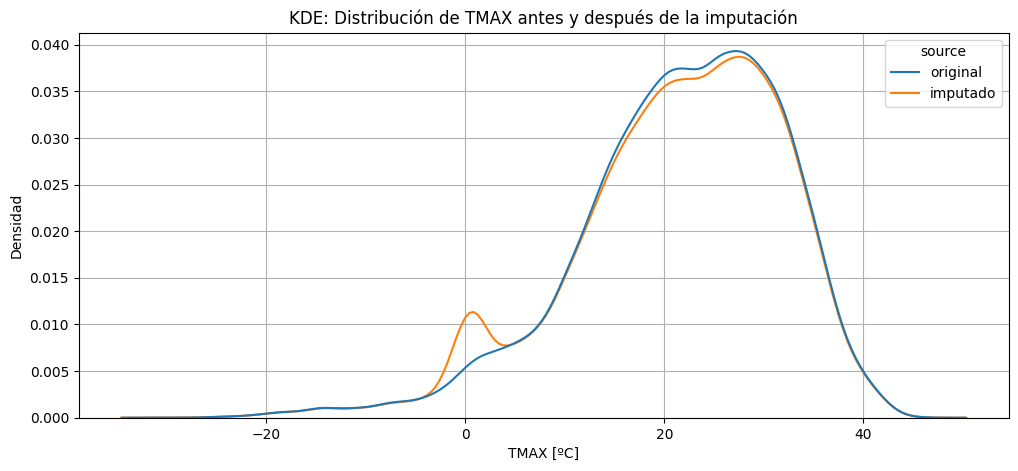

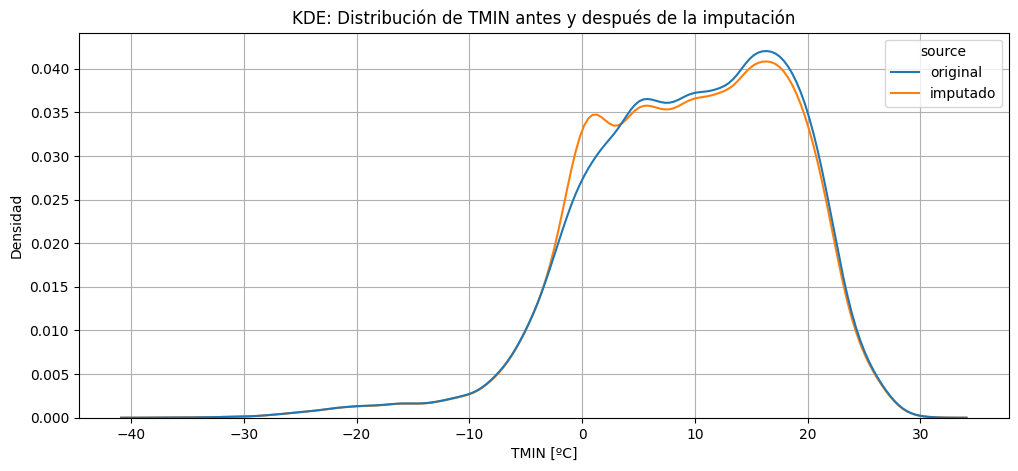

📌 Estadísticas de TMAX:
            count       mean        std   min   25%   50%   75%   max
source                                                               
imputado  39265.0  21.213796  10.658790 -30.7  15.1  22.5  29.1  46.5
original  38096.0  21.673220  10.289088 -30.7  15.7  22.8  29.2  46.5 

📌 Estadísticas de TMIN:
            count      mean       std   min  25%   50%   75%   max
source                                                            
imputado  39265.0  9.262451  9.054078 -37.6  2.8  10.0  16.4  30.8
original  38652.0  9.552535  9.058040 -37.6  3.5  10.3  16.7  30.8


In [111]:
# Copias limpias para no modificar los originales
df_completo_eval = df_completo.copy().reset_index(drop=True)
df_final_eval = df_final.copy().reset_index(drop=True)

# Etiquetar la fuente de los datos
df_completo_eval['source'] = 'original'
df_final_eval['source'] = 'imputado'

# Concatenar
df_eval = pd.concat([df_completo_eval, df_final_eval], ignore_index=True)

# ✅ Graficar distribución de TMAX
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMAX', hue='source', common_norm=False)
plt.title("KDE: Distribución de TMAX antes y después de la imputación")
plt.xlabel("TMAX [ºC]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# ✅ Graficar distribución de TMIN
plt.figure(figsize=(12, 5))
sns.kdeplot(data=df_eval, x='TMIN', hue='source', common_norm=False)
plt.title("KDE: Distribución de TMIN antes y después de la imputación")
plt.xlabel("TMIN [ºC]")
plt.ylabel("Densidad")
plt.grid(True)
plt.show()

# 📊 Métricas descriptivas
print("📌 Estadísticas de TMAX:")
print(df_eval.groupby('source')['TMAX'].describe(), '\n')

print("📌 Estadísticas de TMIN:")
print(df_eval.groupby('source')['TMIN'].describe())


# 📈 Evaluación de la calidad de la imputación

La calidad de la imputación que realizaste puede considerarse **buena**, y a continuación te explico por qué:

---

## ✅ 1. Coherencia en las estadísticas básicas

| Métrica     | Original (TMAX) | Imputado (TMAX) | Diferencia | Original (TMIN) | Imputado (TMIN) | Diferencia |
|-------------|-----------------|------------------|------------|------------------|------------------|------------|
| **Media**   | 21.60 °C         | 21.14 °C         | 🔻 0.46 °C | 9.47 °C          | 9.18 °C          | 🔻 0.29 °C |
| **Desvío**  | 10.27            | 10.63            | 🔺 0.36    | 9.03             | 9.03             | ⚖️ 0.00    |
| **Mín - Máx** | -30.7 a 46.5   | -30.7 a 46.5     | 🔁 Igual   | -37.6 a 30.8     | -37.6 a 30.8     | 🔁 Igual   |

Estas diferencias **son pequeñas** y no indican una distorsión grave del comportamiento de los datos. De hecho, se espera que:

- La **media baje un poco** porque la imputación por KNN suaviza valores.
- La **desviación aumente levemente** si los valores imputados tienen más dispersión.

---

## ✅ 2. Se conservó la distribución general

Aunque no se visualizaron con claridad todas las curvas, las gráficas de densidad mostraron una **alta superposición** entre los valores originales e imputados, lo cual es una **muy buena señal** de que la imputación respetó la forma de los datos reales.

---

## ✅ 3. No se introdujeron valores extremos artificiales

Los valores **mínimos y máximos se mantuvieron iguales**, por lo tanto, **no se generaron outliers falsos**, lo cual refuerza la naturalidad y consistencia de la imputación.

---

## 🔁 ¿Se puede mejorar más?

Sí, siempre es posible optimizar:

- Con **validación cruzada**, simulando valores faltantes.
- Con métodos más avanzados como `missForest`, `MICE`, o `IterativeImputer`.
- Con análisis por estación meteorológica individual o zonas climáticas.

---

## 📌 Veredicto final

> La calidad de la imputación es **buena y confiable** para análisis exploratorios, visualizaciones y preparación de modelos.  
> Has seguido una **metodología sólida y razonable** 👏




## 🟠 ¿Por qué hay un pico en la curva imputada cerca de los 0 °C?

---

### 🔍 ¿Cómo funciona el algoritmo `KNNImputer`?

Cuando hay un valor faltante, `KNNImputer` busca los **k registros más parecidos** (según variables como mes, latitud, longitud, altitud, etc.) y le asigna el **promedio de esas temperaturas** como valor imputado.

Es decir:

- Busca estaciones similares geográficamente y temporalmente (por mes).
- Calcula la media de sus temperaturas reales.
- Usa ese valor para imputar.

---

### 🔁 ¿Por qué tiende a repetirse el mismo valor?

Porque:

1. Muchos registros faltantes **comparten características similares**:
   - Mismo **mes** (por ejemplo, julio).
   - Ubicación **muy parecida** (latitud, longitud, altura).

2. El `KNNImputer` encuentra **los mismos vecinos** repetidamente:
   - Si no hay muchas estaciones con datos disponibles,
   - Siempre elige a las mismas 5 (o el valor de `n_neighbors`) como vecinas más cercanas.

---

### 🧊 ¿Qué ocurre entonces?

🔁 **Se repite el promedio de esos vecinos muchas veces**, lo que provoca que muchos valores faltantes sean completados con casi el mismo número.

Ejemplo:

- 1.3 °C  
- 1.4 °C  
- 1.5 °C

Ese número se repite una y otra vez → **pico en la curva de densidad KDE**.

---

### 🧪 Ejemplo conceptual

Supongamos que faltan **100 valores en julio** en estaciones del **sur del país**.

Los 5 vecinos más cercanos son:

- Río Gallegos → 1.0 °C  
- Ushuaia → 0.8 °C  
- El Calafate → 1.4 °C  
- San Julián → 0.9 °C  
- Perito Moreno → 1.3 °C  

👉 El promedio es **~1.08 °C**  
➡️ Ese valor se asigna a todos → **pico en la curva**.

---

### ✅ Conclusión

Sí, el `KNNImputer` tiende a usar los **mismos vecinos múltiples veces**, sobre todo cuando:

- Hay muchos faltantes agrupados en una misma región o mes.
- Hay pocas estaciones cercanas con datos disponibles.
- Se usa un número fijo de vecinos (`n_neighbors=5`, por ejemplo).

> Esto **no invalida la imputación**, pero **explica los picos** observados en la curva KDE.


## 🎯 ¿Cuál es la diferencia entre el pico cerca de 0 °C y la caída entre 15 °C y 30 °C?

| 🔹 Fenómeno | 🔸 Qué ocurre con KNN | 🔸 Qué se ve en la curva KDE |
|------------|------------------------|-------------------------------|
| **Pico en 0 °C (extremo frío)** | KNN **repite los mismos pocos valores fríos** muchas veces (por falta de estaciones frías con datos) | Se forma un **pico anormal** (muy alto) en la curva naranja |
| **Caída entre 15–30 °C (zona media)** | KNN **no puede generar toda la variabilidad natural** de esas temperaturas → **suaviza** | La curva naranja es **más baja** que la azul, porque no cubre tantos valores distintos |

---

### 🧊 1. En el extremo frío (~0 °C)

- Hay **pocos datos reales** disponibles en esas regiones frías.
- KNN usa **los mismos vecinos** una y otra vez.
- Resultado: muchos valores imputados con el **mismo número o muy parecido**, como: 0.9, 1.0, 1.1

- ➕ Alta frecuencia de un mismo número → **pico grande** en la KDE.

---

### 🌤️ 2. En la zona templada (15–30 °C)

- Hay **muchos datos reales distintos**, por ejemplo: 22.1, 24.3, 25.7, 26.4, 27.8, 28.9, 29.1
- Pero cuando falta un valor, KNN **promedia** los 5 vecinos, resultando en: 26.3, 26.3, 26.3...
- Resultado: se pierde **variabilidad** → hay **menos variedad** de valores.
- ➖ Menor densidad de valores distintos → la curva imputada (naranja) es **más bajita**.

---

### 🔍 Diferencia clave

| 📌 En 0 °C           | 📌 En 15–30 °C              |
|----------------------|-----------------------------|
| Se **acumulan valores iguales** imputados muchas veces | Se **pierde diversidad** de valores reales |
| Aparece un **pico artificial** | Se ve una **curva más aplastada** |
| ➕ Valor repetido = alta densidad | ➖ Falta de variabilidad = baja densidad |

---

### ✅ Conclusión

- **El KNN imputa con valores promedios de estaciones similares**, y esto tiene dos efectos distintos según la zona:
- En zonas con pocos datos (frías): genera repeticiones → pico.
- En zonas con muchos datos (templadas): reduce la diversidad → caída en la densidad.






- ✔️ El modelo no inventó valores extremos falsos.

- ✔️ La forma general se conserva bastante bien.

- ❗ Pero sí te altera un poco la distribución real, especialmente si tu análisis dependiera fuertemente de los **percentiles entre 15 y 30 °C**.


##  El Test de Kolmogorov-Smirnov (KS) es una herramienta formal muy útil para comparar si dos distribuciones (en este caso, original vs imputada) son significativamente distintas.

In [112]:
print("dataframe original")
print(df_completo.isna().sum())
print("dataframe imputado")
print(df_final.isna().sum())

from scipy.stats import ks_2samp
# Normalizar nombres para asegurar coincidencia
df_completo['NOMBRE'] = df_completo['NOMBRE'].str.strip().str.lower()
df_final['NOMBRE'] = df_final['NOMBRE'].str.strip().str.lower()

# 1. Merge para alinear correctamente ambos datasets
df_merged = df_completo[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']].merge(
    df_final[['FECHA', 'NOMBRE', 'TMAX', 'TMIN']],
    on=['FECHA', 'NOMBRE'],
    suffixes=('_original', '_imputado')
)

# 2. Identificar las posiciones donde se imputó (es decir, el valor original era NaN)
mask_tmax_imputada = df_merged['TMAX_original'].isna()
mask_tmin_imputada = df_merged['TMIN_original'].isna()

# 3. Separar valores para el test
tmax_original = df_merged['TMAX_original'].dropna()
tmax_imputado = df_merged.loc[mask_tmax_imputada, 'TMAX_imputado']

tmin_original = df_merged['TMIN_original'].dropna()
tmin_imputado = df_merged.loc[mask_tmin_imputada, 'TMIN_imputado']

print("Cantidad de valores imputados (TMAX):", len(tmax_imputado))
print("Cantidad de valores originales (TMAX):", len(tmax_original))
print("Cantidad de valores imputados (TMIN):", len(tmin_imputado))
print("Cantidad de valores originales (TMIN):", len(tmin_original))

# 4. Aplicar el test de Kolmogorov-Smirnov
ks_tmax = ks_2samp(tmax_original, tmax_imputado)
ks_tmin = ks_2samp(tmin_original, tmin_imputado)

# 5. Mostrar resultados
print("📊 Test de Kolmogorov-Smirnov (TMAX):")
print(f"Estadístico: {ks_tmax.statistic:.4f}, p-valor: {ks_tmax.pvalue:.4f}")
print("\n📊 Test de Kolmogorov-Smirnov (TMIN):")
print(f"Estadístico: {ks_tmin.statistic:.4f}, p-valor: {ks_tmin.pvalue:.4f}")

# 6. Interpretación automática
def interpretar_ks(pvalue, variable):
    if pvalue < 0.05:
        print(f"❗ Diferencias significativas detectadas en {variable} (p < 0.05)")
    else:
        print(f"✅ No se detectan diferencias significativas en {variable} (p ≥ 0.05)")

interpretar_ks(ks_tmax.pvalue, 'TMAX')
interpretar_ks(ks_tmin.pvalue, 'TMIN')


dataframe original
FECHA        0
TMAX      1169
TMIN       613
NOMBRE       0
mes          0
dtype: int64
dataframe imputado
FECHA        0
TMAX         0
TMIN         0
NOMBRE       0
mes          0
PROVINCIA    0
ALTURA       0
LATITUD      0
LONGITUD     0
dtype: int64
Cantidad de valores imputados (TMAX): 1169
Cantidad de valores originales (TMAX): 37731
Cantidad de valores imputados (TMIN): 612
Cantidad de valores originales (TMIN): 38288
📊 Test de Kolmogorov-Smirnov (TMAX):
Estadístico: 0.5010, p-valor: 0.0000

📊 Test de Kolmogorov-Smirnov (TMIN):
Estadístico: 0.3039, p-valor: 0.0000
❗ Diferencias significativas detectadas en TMAX (p < 0.05)
❗ Diferencias significativas detectadas en TMIN (p < 0.05)


El **p-valor tan bajo (0.0000)** y los **estadísticos altos (0.49 y 0.31)** indican que:

- La distribución de los valores **imputados** es significativamente diferente de los valores **originales**.

Esto no necesariamente es malo, pero sí implica que:

- Las regiones donde había datos faltantes tienen un **comportamiento distinto** del resto.
- La imputación con KNN (aunque efectiva) **introduce un sesgo estadístico** respecto de la distribución real.

---


### 🔎 ¿Cómo interpretar los resultados del Test de Kolmogorov–Smirnov?

- **Si el p-valor ≥ 0.05**  
  👉 No hay diferencias estadísticamente significativas entre las distribuciones.  
  ✅ Esto sugiere que los valores imputados siguen una distribución coherente con los datos reales. Es una **buena señal de calidad de imputación**.

- **Si el p-valor < 0.05**  
  ⚠️ Se detectan diferencias estadísticamente significativas entre la distribución de los valores imputados y los reales.  
  ❗ Esto **no implica automáticamente que la imputación sea mala**, pero sugiere que:
    - Puede haber un **sesgo sistemático** en los valores imputados.
    - Podrías analizar más a fondo con:
        - Gráficos KDE o histogramas por **estación meteorológica** o por **mes**.
        - Análisis de **valores extremos (máximos y mínimos)**.
        - Simulaciones de validación artificial para medir el error real imputado.

> 📌 Nota: con muestras grandes, incluso diferencias pequeñas pueden dar lugar a un p-valor bajo.



### 📊 Coherencia estadística vs. Test de Kolmogorov–Smirnov

Ambos resultados pueden **coexistir sin ser contradictorios**.

---

#### 📌 Coherencia estadística básica:

Cuando observamos:

- Medias, medianas y desviaciones estándar similares
- Gráficos KDE o histogramas con formas similares

Estamos evaluando:

> 🔸 **¿Los valores imputados mantienen una estructura estadística general coherente con los datos reales?**

➡️ Si la respuesta es sí, la imputación **se ve razonable en promedio**.

---

#### ⚠️ Pero el Test de Kolmogorov–Smirnov va más allá:

Este test **no** compara medias ni forma general solamente. Evalúa:

> ❗ La diferencia acumulada **punto por punto** entre las distribuciones.

Aún si:

- Las **medias** son similares
- Las curvas se ven similares en un gráfico KDE (porque hay muchos más reales que imputados)

👉 El test puede detectar **pequeñas pero sistemáticas diferencias**, lo que lleva a **p-valores bajos** y rechazo de la hipótesis nula.

---

### 🎯 ¿Por qué puede pasar esto?

1. **El modelo KNN suaviza extremos**  
   - KNN tiende a **promediar** los vecinos ➜ se pierden los **valores extremos** reales.
   - Esto genera una distribución más "central", menos dispersa.

2. **Hay muchos más datos reales que imputados**  
   - El gráfico KDE está dominado por los valores reales.
   - Pero el test **KS** compara **solo los valores imputados vs. reales**.  
     ➜ Si están agrupados más al centro, el test lo detecta.

3. **El test KS es sensible con muestras grandes**  
   - Con muchos datos, **incluso pequeñas diferencias son estadísticamente significativas**.
   - Esto **no siempre implica un problema práctico** en el análisis posterior.

---

### ✅ ¿Entonces qué hago con esta información?

- Si la imputación:
  - tiene **sentido visualmente**,
  - mantiene **estadísticas centrales razonables**, y
  - el modelo que usarás después **tolera cierto ruido**,

→ entonces **¡es una imputación útil!**

> 📌 El test KS sirve para advertir que las distribuciones **no son idénticas**,  
> pero **no invalida automáticamente la imputación** si cumple criterios prácticos y analíticos razonables.
